In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from numba import jit
from modules.process import Process
from modules.edge import get_bright_edge
from modules.mass_center import compute_mass_center
from modules.bright2dark import get_b2d_data
from modules.dense_area import get_dense_area
from modules.grouping import divideIntoGroups
from modules.helper import get_extention_tag, display_images
from modules.fft import lowpass_filter
from modules.fitting import fit2circle
from modules.mask import to_mask, get_dilated_mask
from modules.contour import get_largest_brightness_diff_contour_id, select_concentric_contour_indices
from config import base_dir

In [ ]:
def delete_drawings(image):
    ret = cv2.circle(image, (375, 356), 80, 0, thickness=5)
    ret[:100, :300] = 0
    ret[600:, 580:] = 0
    return ret

def test_run(instance, index):
    gray = instance.gray_images[index]

    # mass center
    dilated_dust_mask = get_dilated_mask(instance.dust_mask)
    cx, cy = compute_mass_center(gray, dilated_dust_mask)

    # edge points
    edge = get_bright_edge(gray)
    edge[dilated_dust_mask == 1] = 0
    edge = delete_drawings(edge)

    # b2d data
    blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
    b2d_vector_image, cos_image = get_b2d_data(blurred, cx, cy, sobel_ksize=3)

    # b2d mask
    b2d_mask = np.ones(gray.shape)
    b2d_mask[cos_image < 0.3] = 0
    b2d_mask[b2d_vector_image < np.mean(b2d_vector_image)] = 0
    b2d_mask = delete_drawings(b2d_mask)
    group_sizes, grouped = divideIntoGroups(b2d_mask, ksize=3)
    small_group_mask = np.zeros(b2d_mask.shape)
    for group_id, group_size in enumerate(group_sizes):
        if group_size < 50:
            small_group_mask[grouped == group_id] = 1
    new_b2d_mask = np.copy(b2d_mask)
    new_b2d_mask[small_group_mask == 1] = 0

    # 境界点群の絞り込み
    new_edge = np.copy(edge)
    new_edge[new_b2d_mask == 0] = 0
    new_edge_binary = np.copy(new_edge)
    new_edge_binary[new_edge_binary > 0] = 1
    new_edge_binary = cv2.dilate(new_edge_binary, kernel=(5, 5))

    # 輪郭群の検出と絞り込み
    contours, _ = cv2.findContours(new_edge_binary.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
    standard_contour_id = get_largest_brightness_diff_contour_id(contours, new_edge_binary, b2d_vector_image, instance.dust_mask)
    concentric_contour_indices = select_concentric_contour_indices(contours, standard_contour_id, circle_thickness=10)
    concentric_contours = [c for i, c in enumerate(contours) if i in concentric_contour_indices]
    ellipse = cv2.fitEllipseAMS(np.concatenate(concentric_contours))
    circle = fit2circle(concentric_contours)
    print(f'Fitting result:\n ellipse{ellipse}\n circle {circle}')

    canvas_standard_contour = gray.copy()
    cv2.drawContours(canvas_standard_contour, [contours[standard_contour_id]], 0, 0, 3)
    canvas_concentric_contours = gray.copy()
    for i, contour in enumerate(concentric_contours):
        cv2.drawContours(canvas_concentric_contours, [contour], 0, 0, 1)
    canvas_all_contours = gray.copy()
    for i, contour in enumerate(contours):
        cv2.drawContours(canvas_all_contours, [contour], 0, 0, 1)
    
    print(f'Number of concentric contours: {len(concentric_contours)}')
    canvas_ellipse = gray.copy()
    cv2.ellipse(canvas_ellipse, ellipse, color=0, thickness=1)
    canvas_circle = gray.copy()
    circle_x, circle_y, circle_rad = map(int, circle)
    cv2.circle(canvas_circle, (circle_x, circle_y), circle_rad, color=0, thickness=1)
    
    # 描画
    images = [gray, edge, b2d_vector_image, cos_image, b2d_mask, new_b2d_mask, new_edge, new_edge_binary, canvas_standard_contour, canvas_concentric_contours, canvas_all_contours, canvas_ellipse, canvas_circle]
    names = ['gray', 'edge', 'b2d_vector', 'b2d_cos', 'b2d_mask', 'new_b2d_mask', 'new_edge', 'new_edge_binary', 'canvas_standard_contour', 'canvas_concentric_contours', 'canvas_all_contours', 'canvas_ellipse', 'canvas_circle']
    w = int(min(len(images) / 2, 4))
    display_images(images, names, w)
    
    return gray, edge, b2d_vector_image, cos_image, b2d_mask, new_b2d_mask, new_edge, new_edge_binary

In [20]:
filenames = [f for f in os.listdir(base_dir) if get_extention_tag(f) == 'tif']
paths = [base_dir + f for f in filenames]
instance = Process(paths)

In [22]:
instance

Fitting result:
 ellipse((438.34503173828125, 326.6976623535156), (396.2202453613281, 420.8433532714844), 89.0632095336914)
 circle (439.2309503438876, 325.4746480360624, 202.99141535035443)
Number of concentric contours: 61


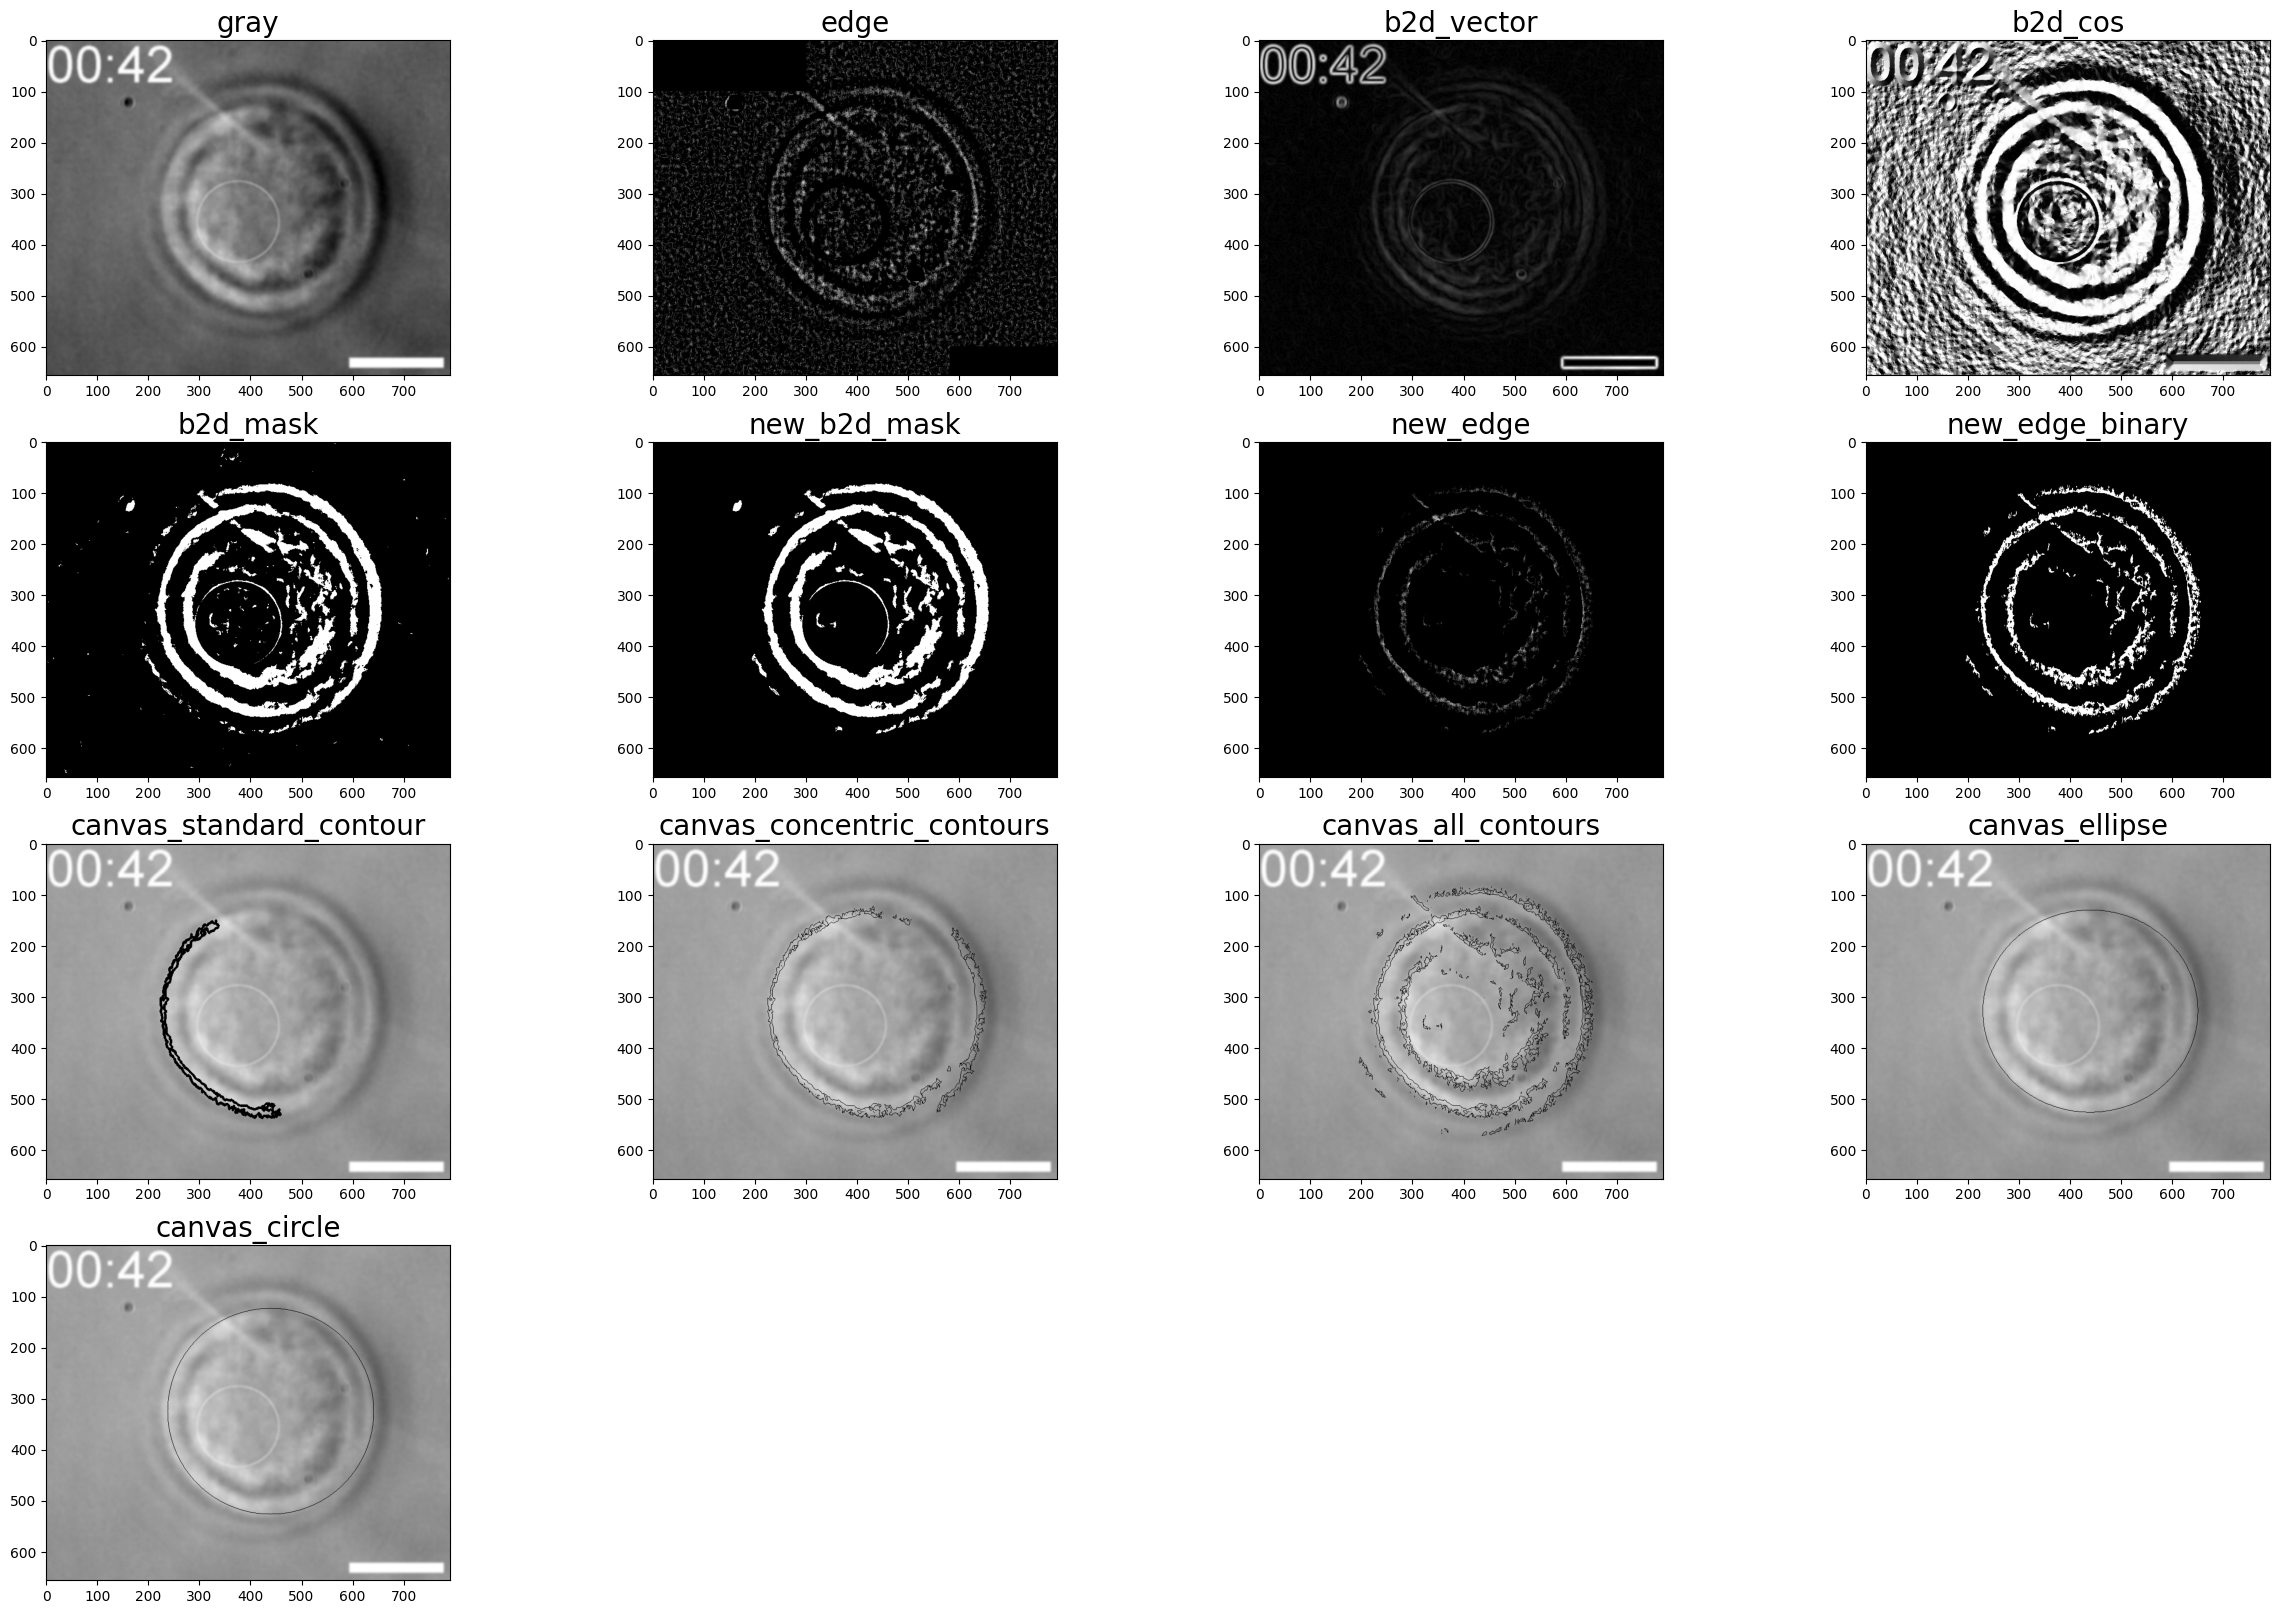

In [23]:
index = 42
gray = instance.gray_images[index]
gray, edge, b2d_vector_image, cos_image, b2d_mask, new_b2d_mask, new_edge, new_edge_binary = test_run(instance, index)

# b2d maskを洗練する
使えなさそう

1 3 3


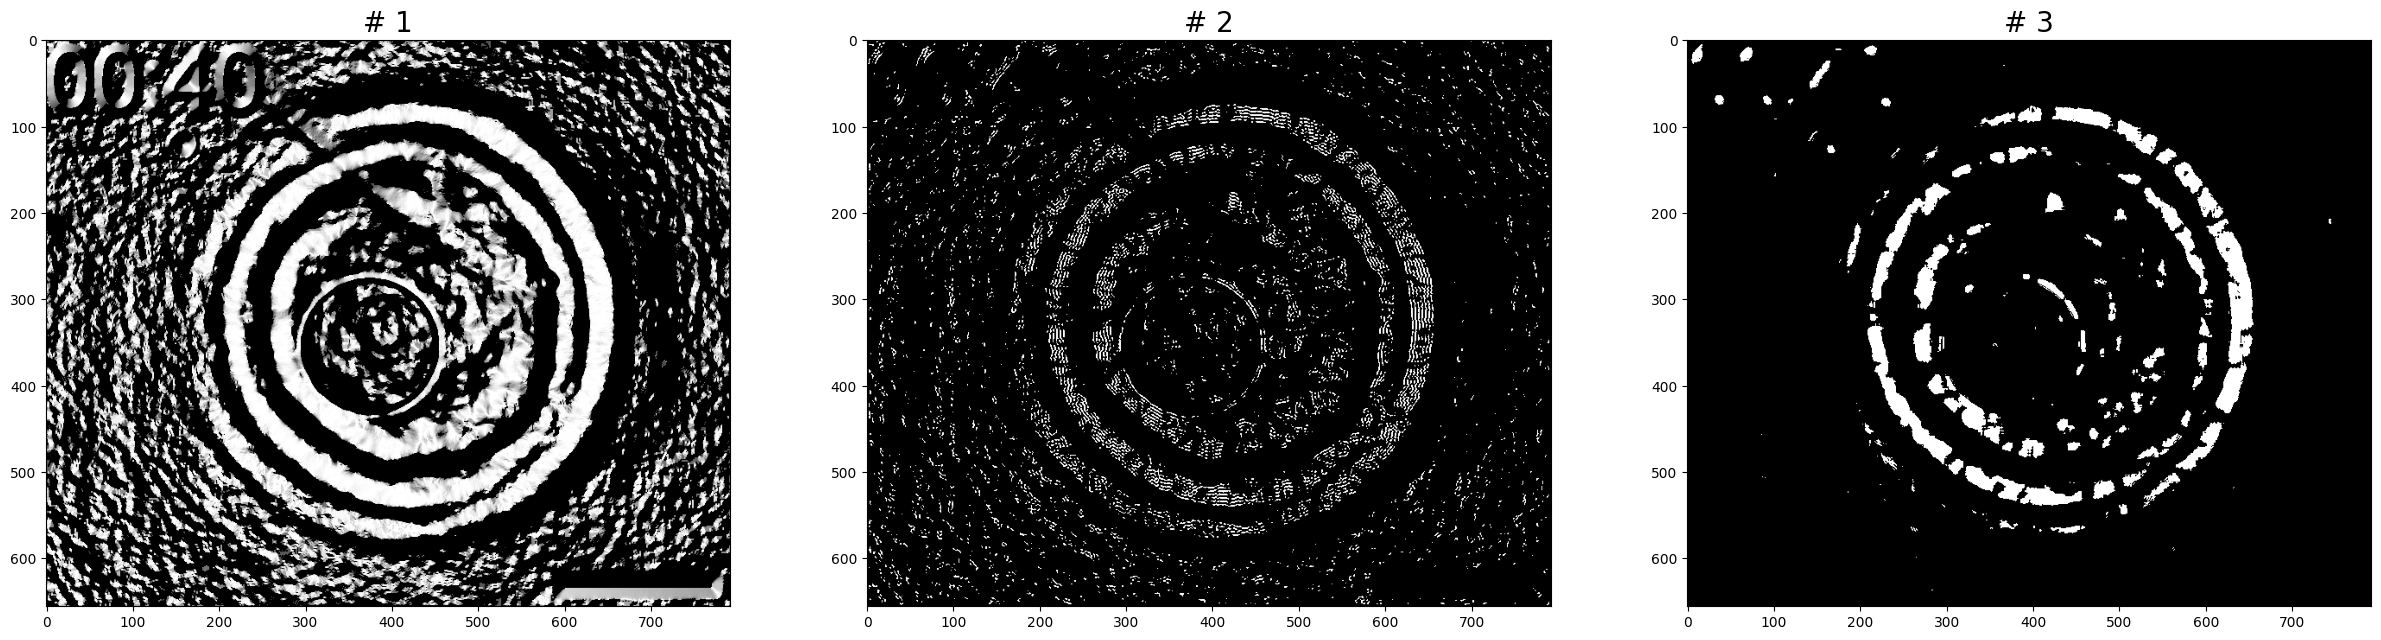

In [73]:
cos2 = cos_image.copy()
cos2[cos2 < 0.3] = 0
img = lowpass_filter(cos2, 0.5)
img2 = get_dense_area(img, ksize=9, thresh_density=0.2)
img2[b2d_vector_image < np.mean(b2d_vector_image)] = 0
display_images([cos2, img, img2])

# 輪郭を厳選して、液滴を楕円近似する

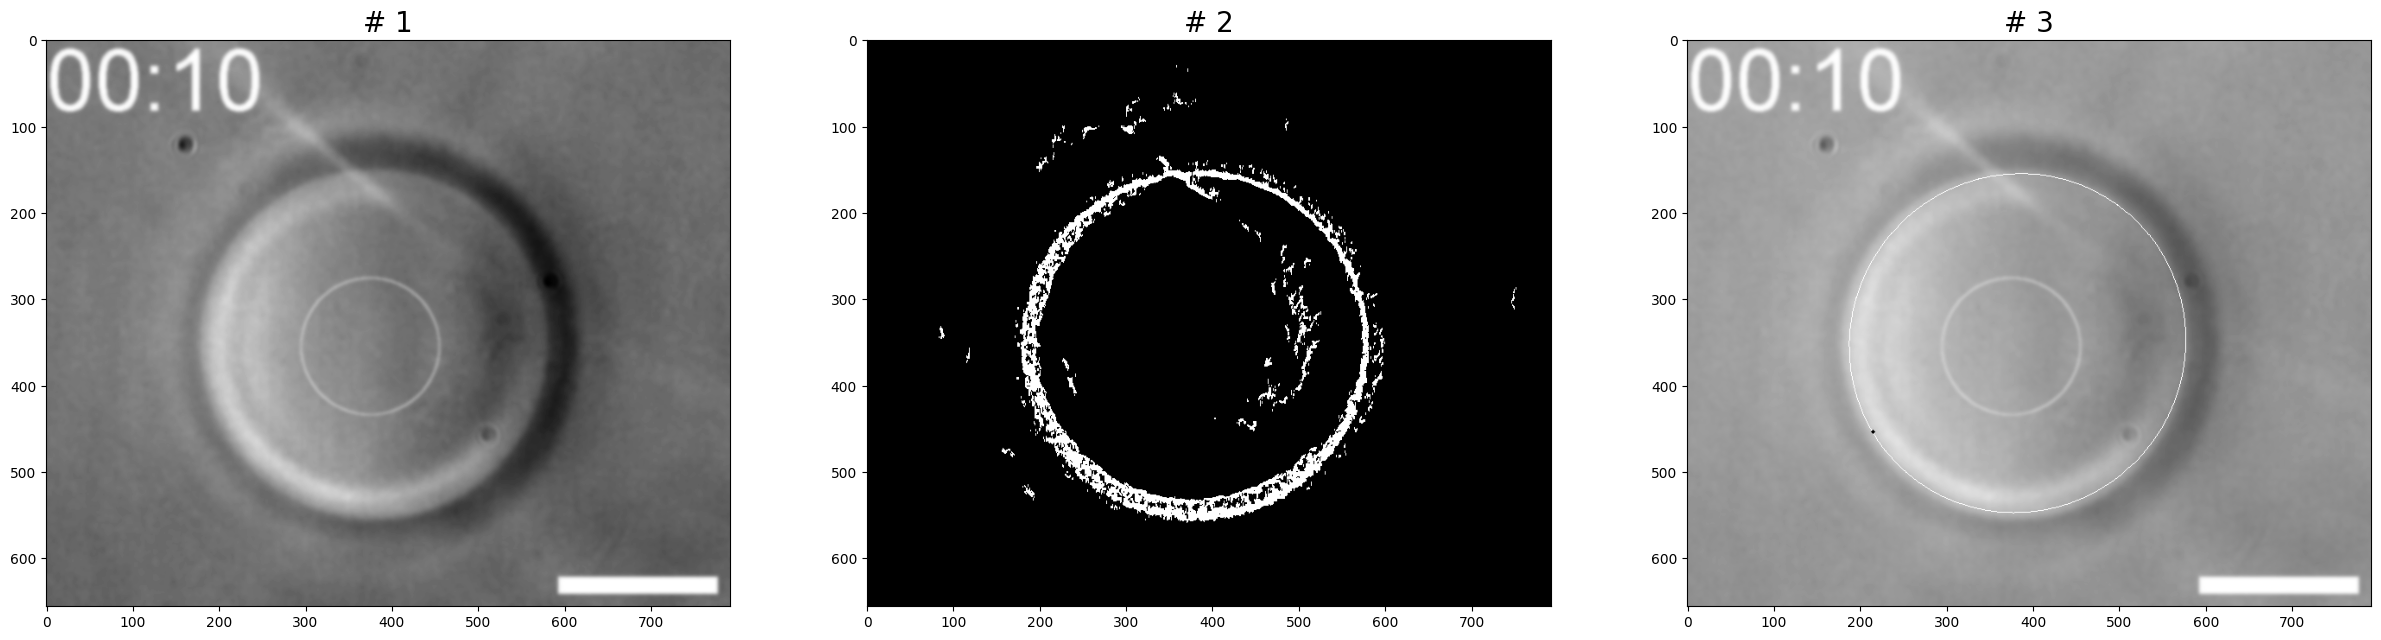

In [10]:
contours, _ = cv2.findContours(new_edge_binary.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
standard_contour_id = get_largest_brightness_diff_contour_id(contours, new_edge_binary, b2d_vector_image, p.dust_mask)
concentric_contour_indices = select_concentric_contour_indices(contours, standard_contour_id, circle_thickness=10)
concentric_contours = np.concatenate([c for i, c in enumerate(contours) if i in concentric_contour_indices])
ellipse = cv2.fitEllipseAMS(concentric_contours)

canvas = gray.copy()
cv2.ellipse(canvas, ellipse, color=255, thickness=1)
cv2.drawContours(canvas, concentric_contours, 0, 0, 3)
display_images([gray, new_edge_binary, canvas])

417.2382401889558 325.8856241465649 195.73178864391446
1 2 2


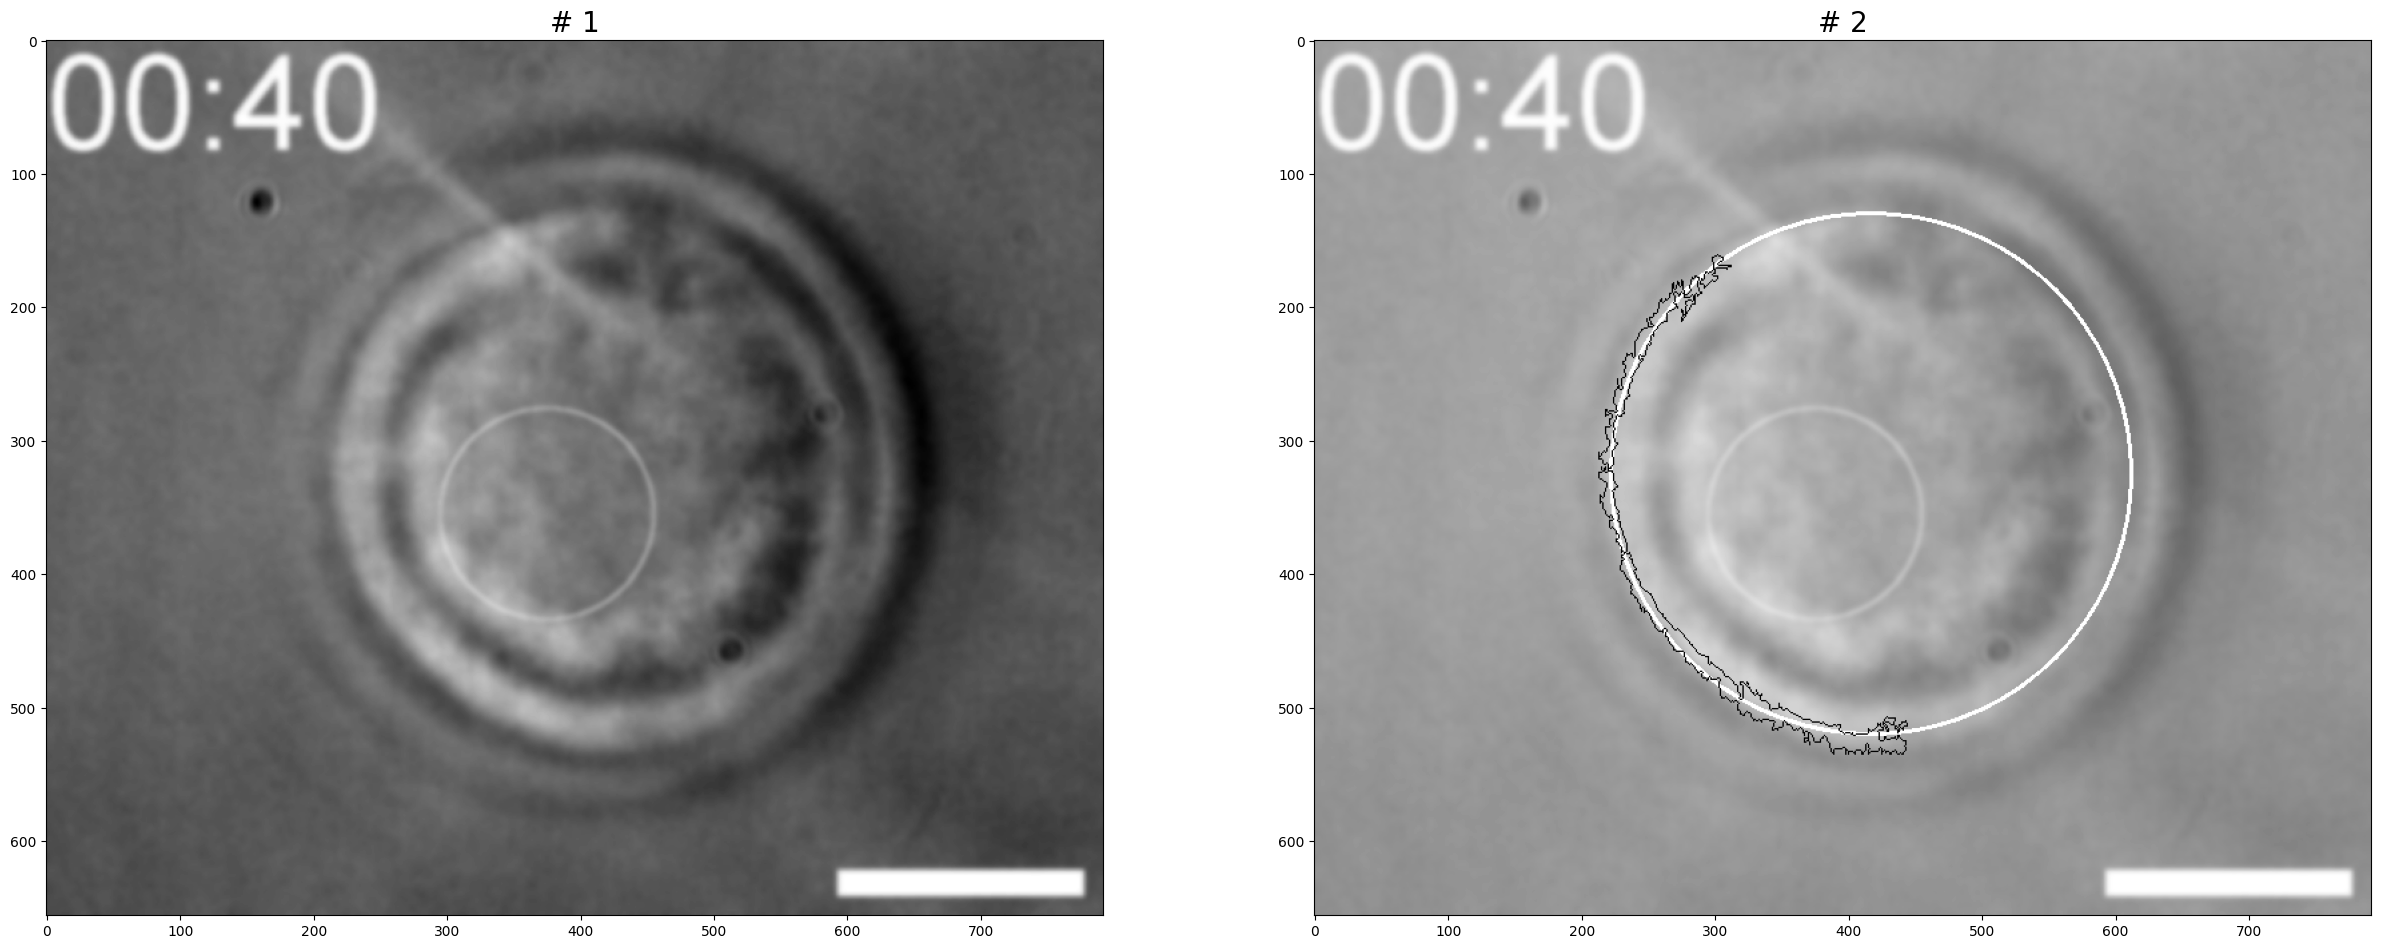

In [38]:
x, y, r = fit2circle([contours[236]])
print(x, y, r)
canvas = gray.copy()
cv2.circle(canvas, (int(x), int(y)), int(r), 255, 2)
cv2.drawContours(canvas, [contours[236]], 0, 0, 1)
display_images([gray, canvas])

In [46]:
def is_inside_circle(x, y, cx, cy, cr):
    return (x - cx)**2 + (y - cy)**2 <= cr**2

def does_cross_contour_and_circle(contour, cx, cy, cr, width=2):
    for p in contour:
        x, y = p[0]
        if is_inside_circle(x, y, cx, cy, cr + width / 2) and not is_inside_circle(x, y, cx, cy, cr - width/2):
            return True
    return False

valid_contour_indices = []
for i, contour in enumerate(contours):
    if len(contour) < 1:
        continue
    if does_cross_contour_and_circle(contour, x, y, r, width=10):
        valid_contour_indices.append(i)
print(valid_contour_indices)

[15, 22, 23, 24, 25, 38, 44, 53, 59, 61, 63, 95, 96, 99, 157, 172, 189, 202, 207, 210, 218, 219, 230, 232, 233, 236, 245, 247, 248, 250, 251, 254, 255, 257]


1 2 2


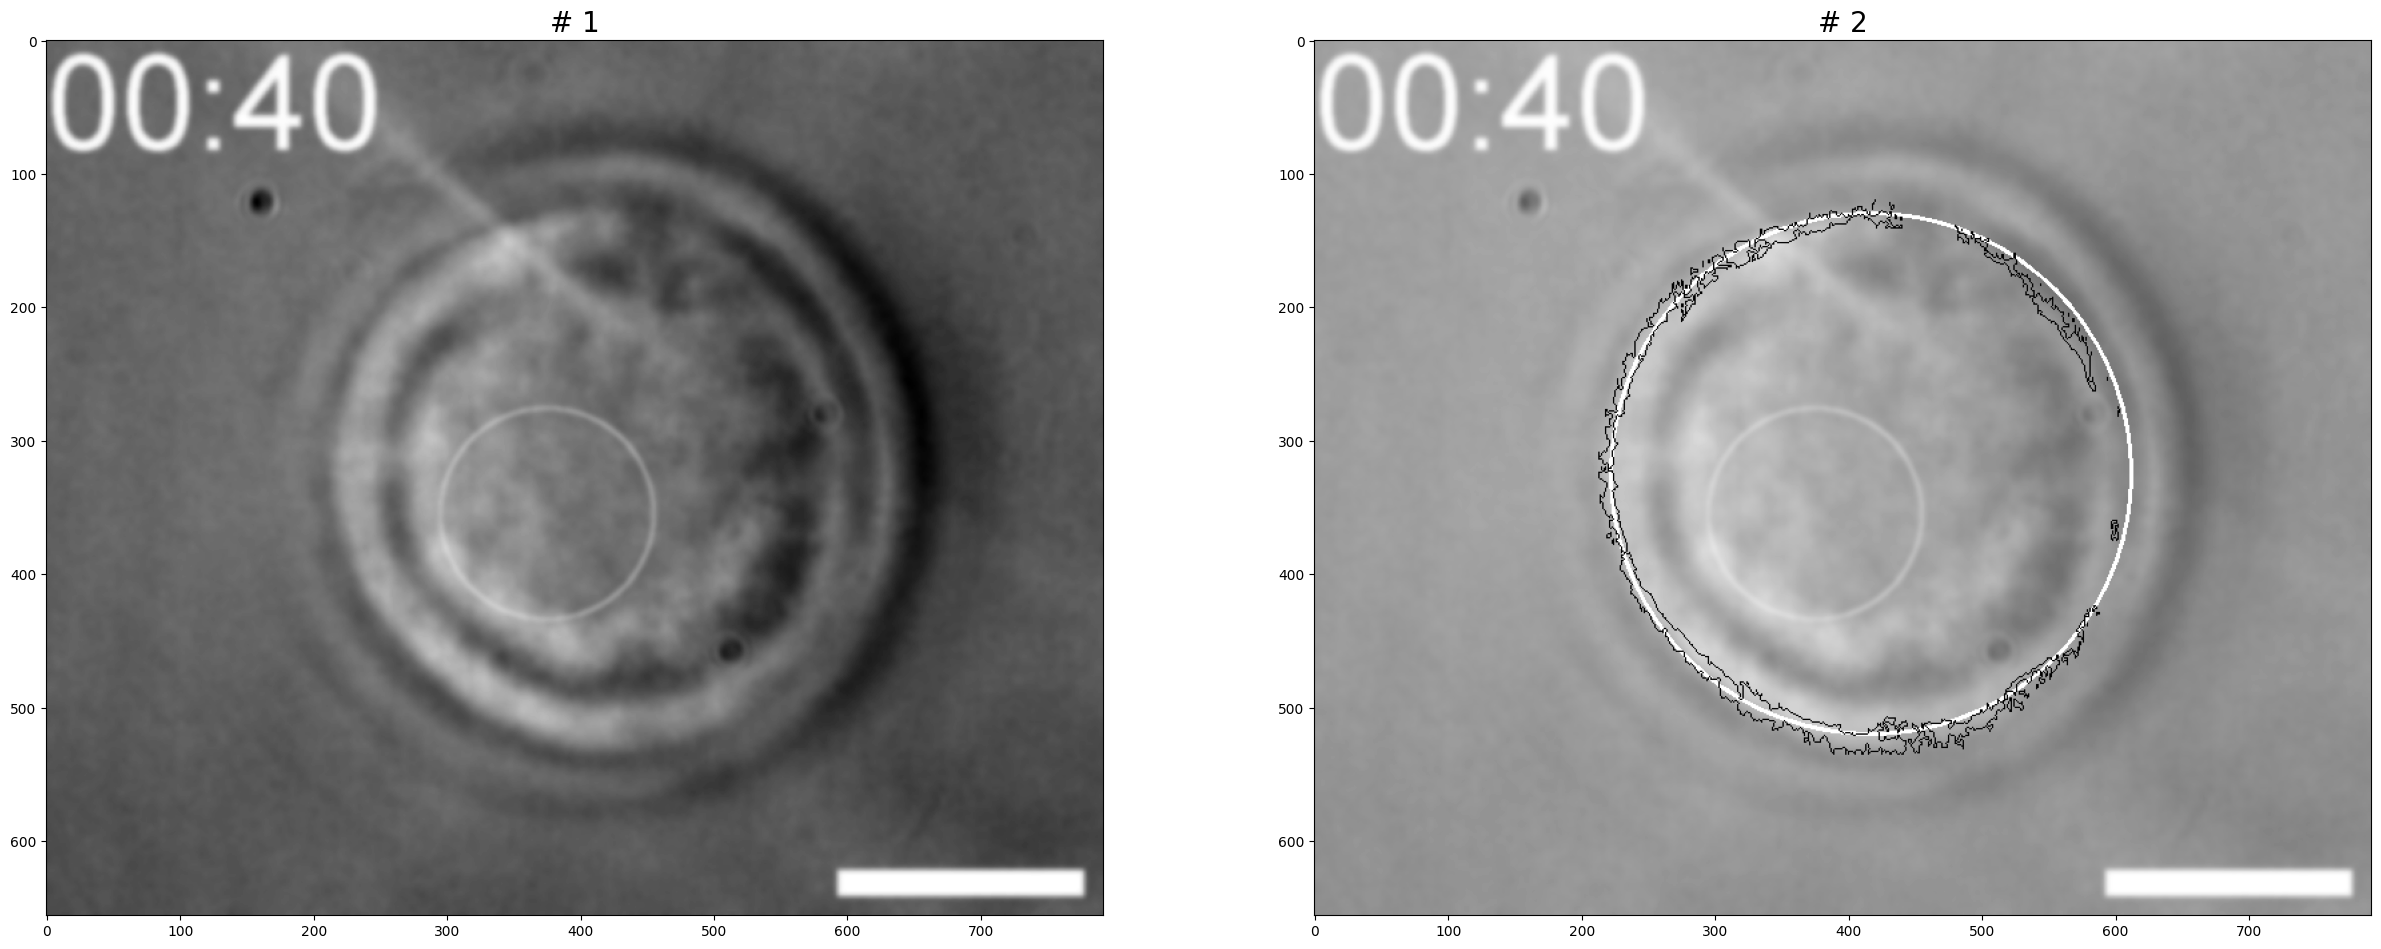

In [47]:
canvas = gray.copy()
cv2.circle(canvas, (int(x), int(y)), int(r), 255, 2)
for i in valid_contour_indices:
    cv2.drawContours(canvas, [contours[i]], 0, 0, 1)
display_images([gray, canvas])

1 2 2


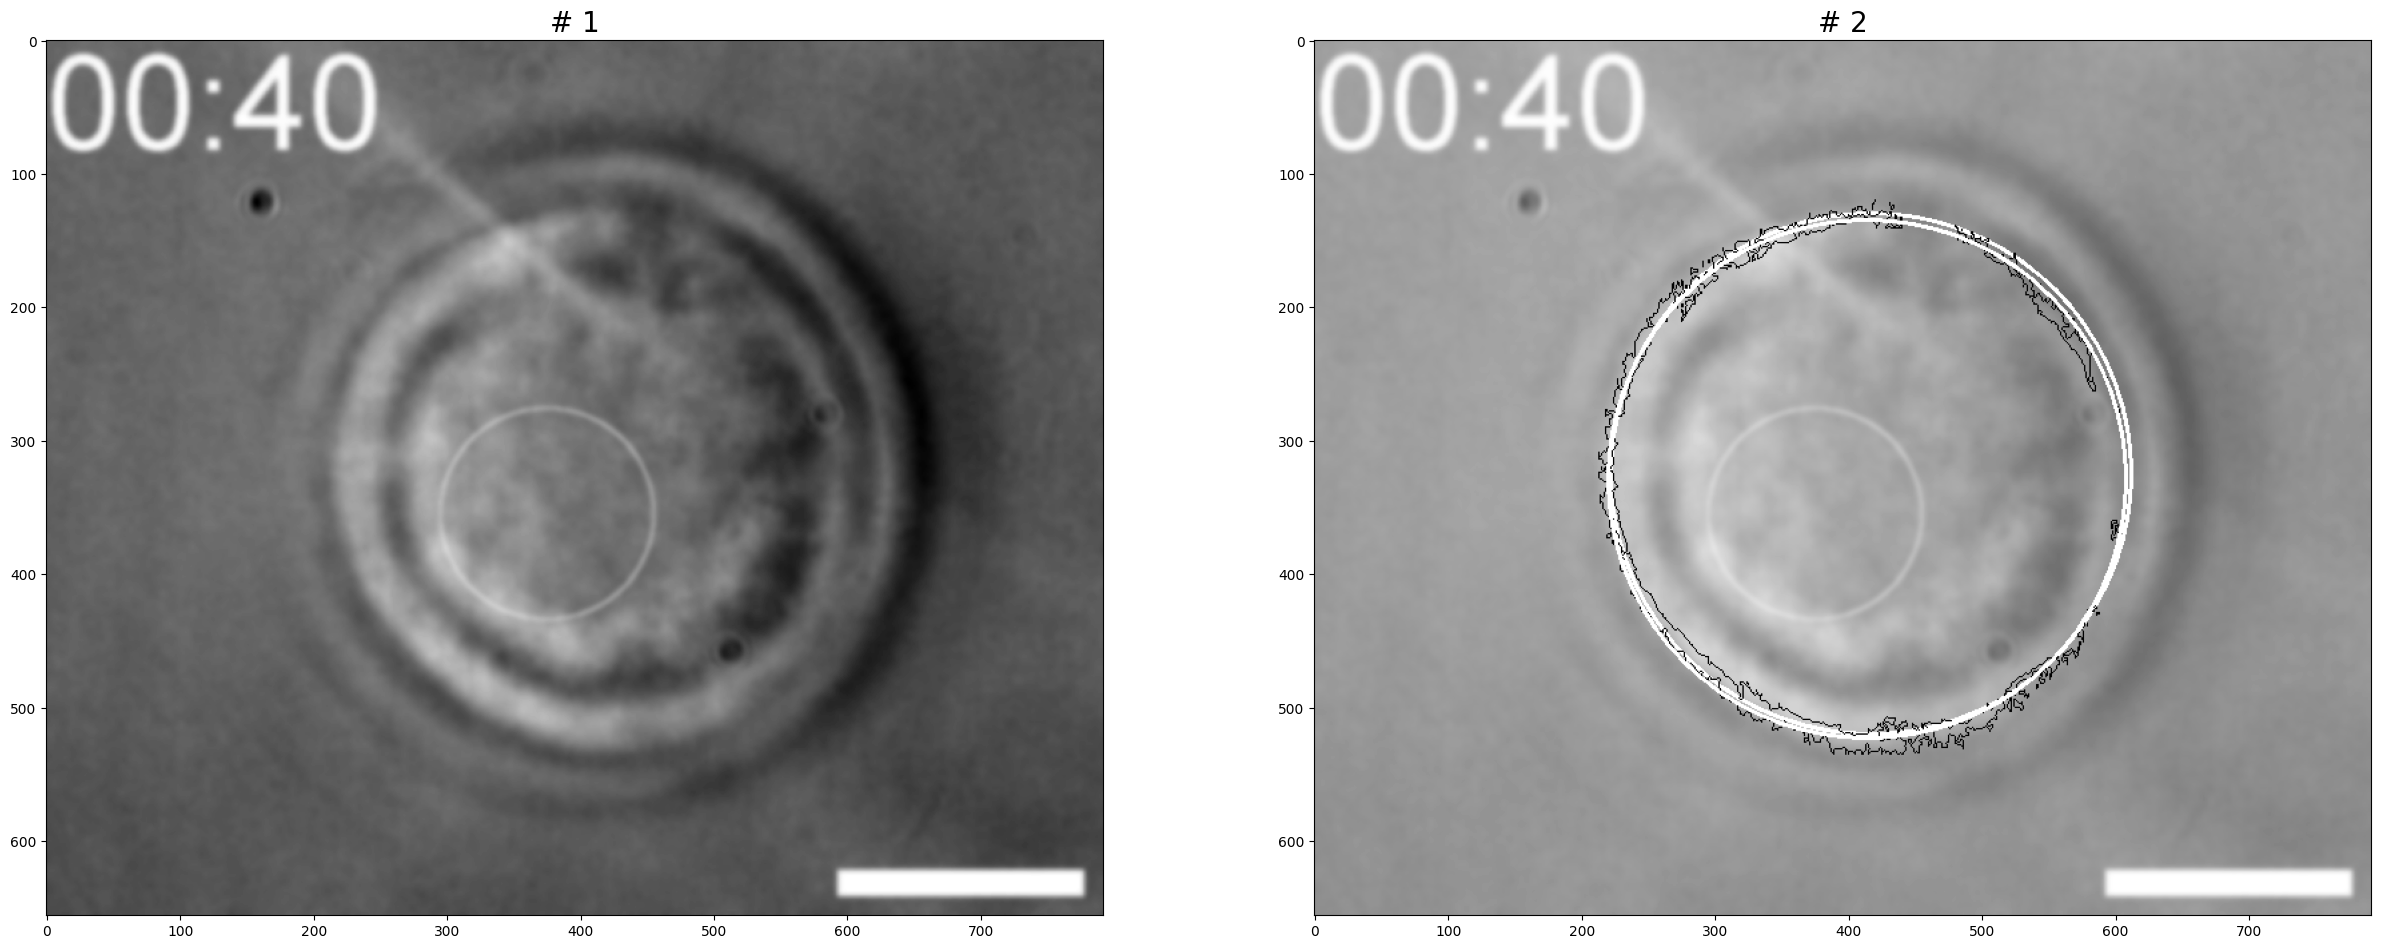

In [50]:
nx, ny, nr = fit2circle([c for i, c in enumerate(contours) if i in valid_contour_indices])
cv2.circle(canvas, (int(nx), int(ny)), int(nr), 255, 2)
display_images([gray, canvas])

1 2 2


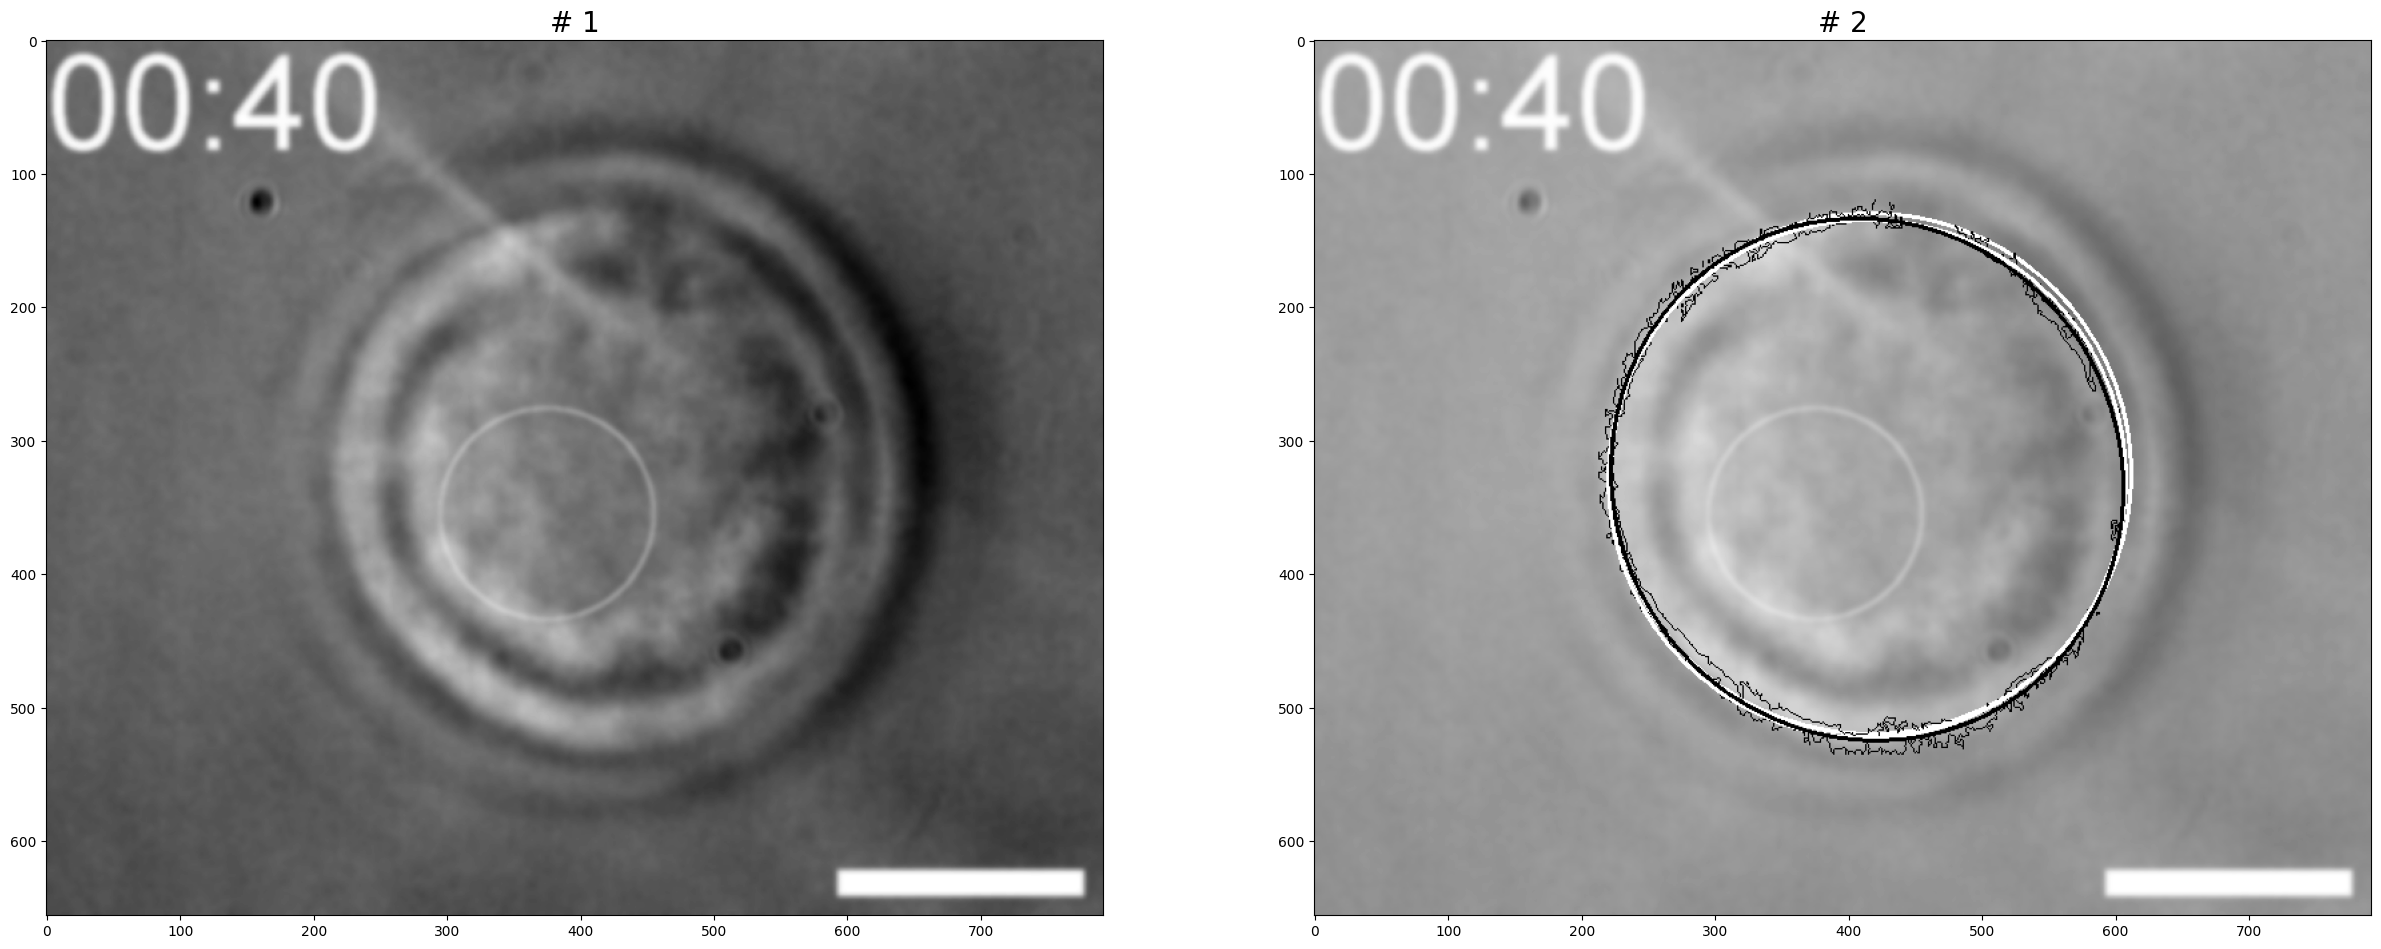

In [53]:
e = cv2.fitEllipseAMS(np.concatenate([c for i, c in enumerate(contours) if i in valid_contour_indices]))
cv2.ellipse(canvas, e, color=0, thickness=2)
display_images([gray, canvas])

In [54]:
e

((414.05596923828125, 329.3940124511719),
 (379.4571228027344, 395.50213623046875),
 147.93307495117188)

In [59]:
e[1][0] ** 2  + e[1][1] ** 2, 2 * (nr * 2)**2

(300409.6478085937, 301389.53146651527)

# 明度差が最大のcontourを抽出する

1 2 2


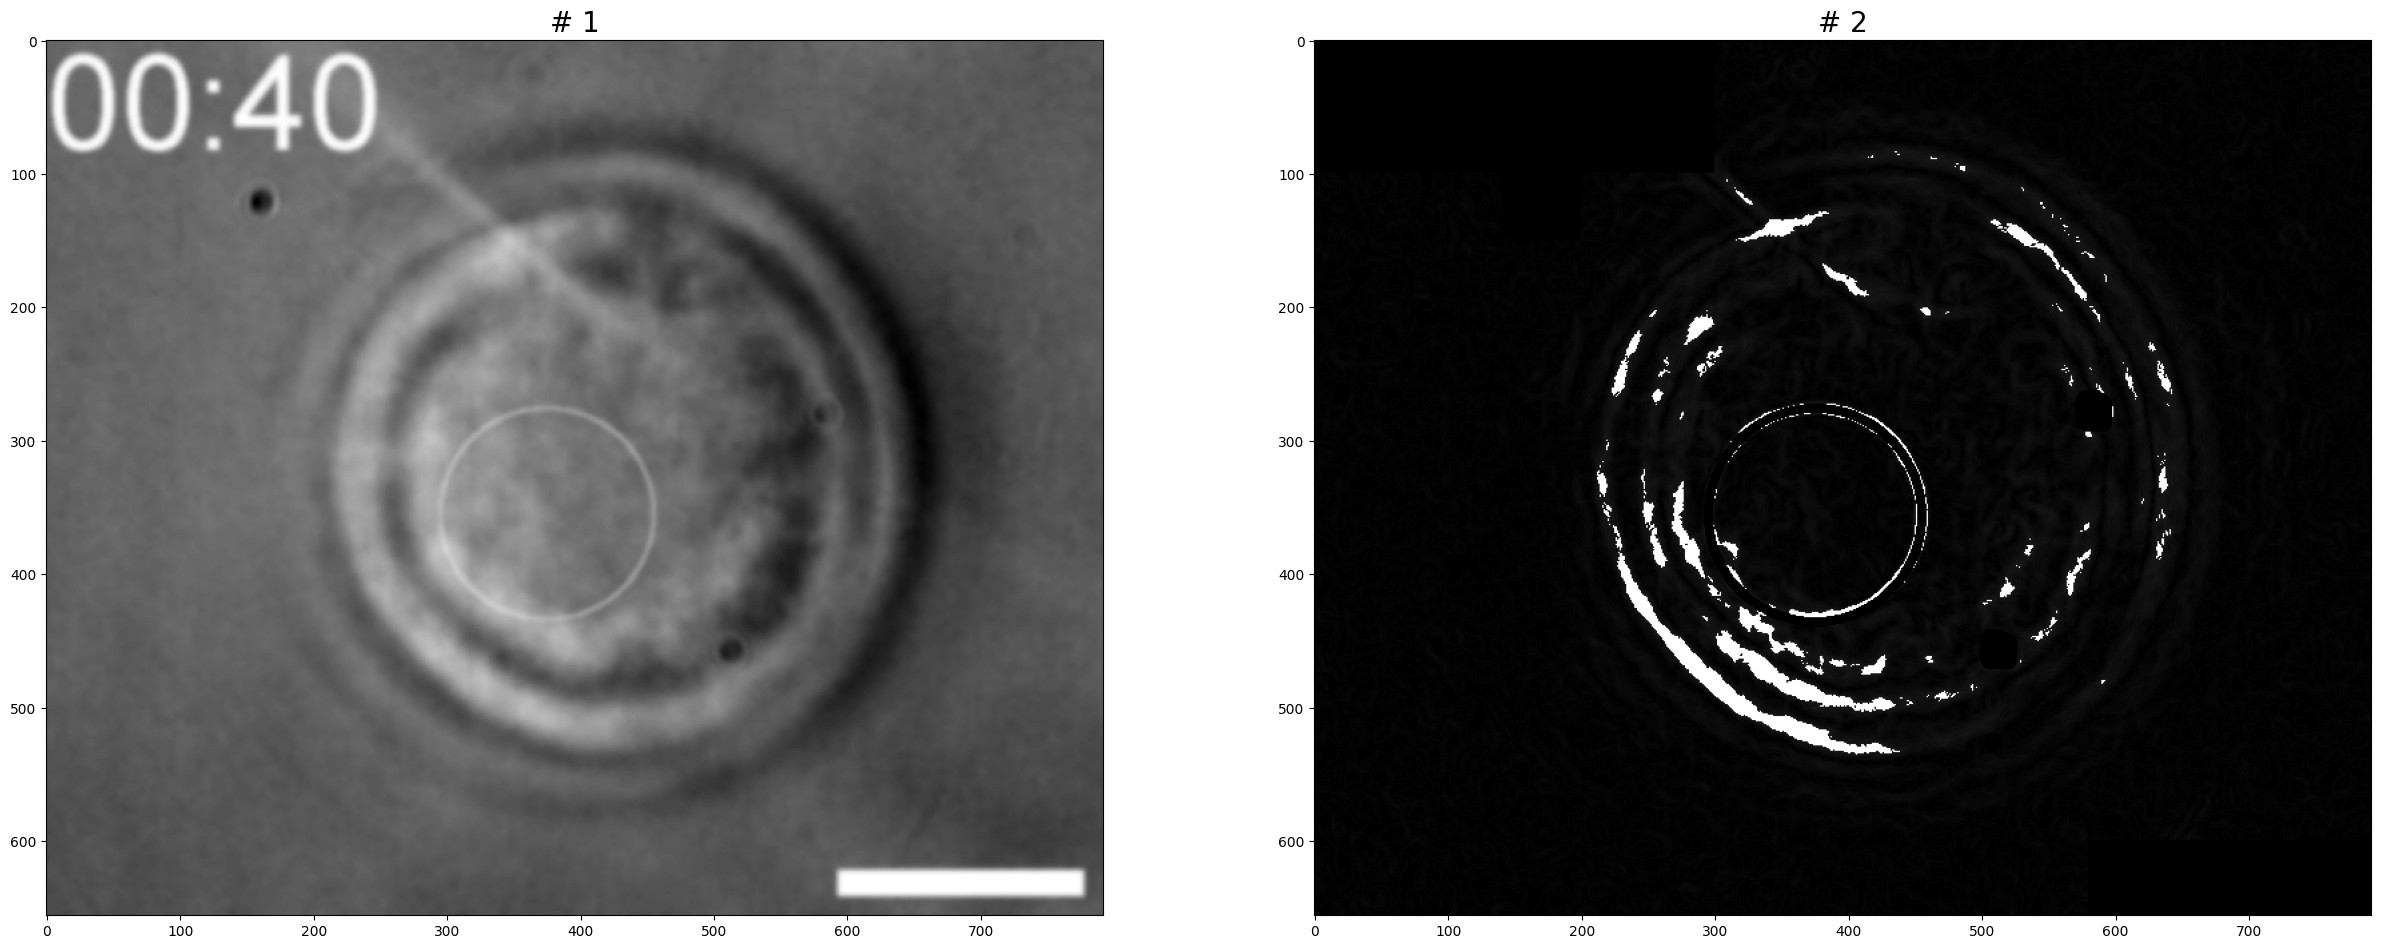

In [90]:
canvas = b2d_vector_image.copy()
canvas = delete_drawings(canvas)
canvas[get_dilated_mask(p.dust_mask) == 1] = 0
canvas[100:150, 140:200] = 0
canvas[canvas >= np.mean(b2d_vector_image) + np.std(b2d_vector_image)] = 255
# for i in valid_contour_indices:
#     cv2.drawContours(canvas, [contours[i]], 0, 50, 5)
display_images([gray, canvas])

In [ ]:
# グルーピング
nlabels, labels = cv2.connectedComponents(new_edge_binary.astype('uint8'))
count_labels = np.zeros(nlabels)
for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        label_id = labels[y, x]
        if label_id == 0:
            continue
        count_labels[label_id] += 1

large_label_indices = [label_id for label_id in range(nlabels) if count_labels[label_id] >= 500]
print(large_label_indices)

[0, 29, 33, 42, 51, 91, 135, 205, 227, 232, 249]


51
1 3 3


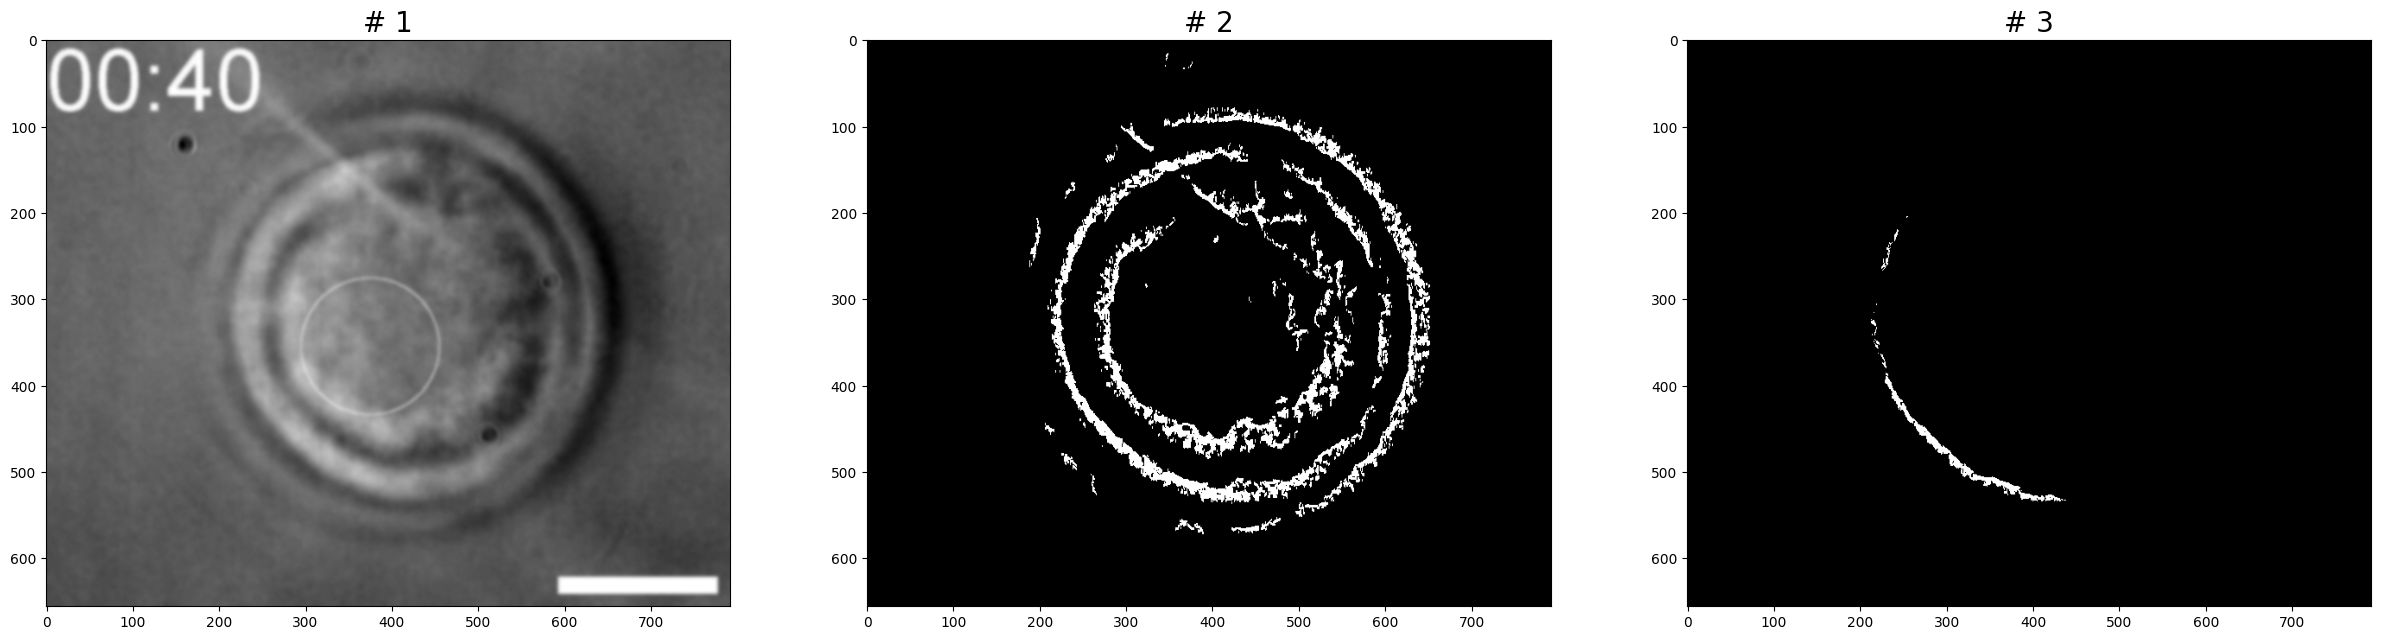

In [142]:
index = 4
label_id = large_label_indices[index]
print(label_id)

msk = labels.copy()
msk[labels != label_id] = 0
display_images([gray, new_edge_binary, msk])

In [149]:
# 一定以上の明度差をもつピクセルを最も多く含むグループを取得

large_diff_mask = b2d_vector_image.copy()
large_diff_mask = delete_drawings(large_diff_mask)
large_diff_mask[get_dilated_mask(p.dust_mask) == 1] = 0
large_diff_mask[100:150, 140:200] = 0
large_diff_mask[large_diff_mask < np.mean(b2d_vector_image) + np.std(b2d_vector_image)] = 0
large_diff_mask[large_diff_mask > 0] = 1
large_diff_mask = large_diff_mask.astype('uint8')

labels[large_diff_mask == 0] = 0
count_masked_labels = np.zeros(nlabels)
for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        label_id = labels[y, x]
        if label_id == 0:
            continue
        count_masked_labels[label_id] += 1

largest_label_id = np.argmax(count_masked_labels)

1 3 3


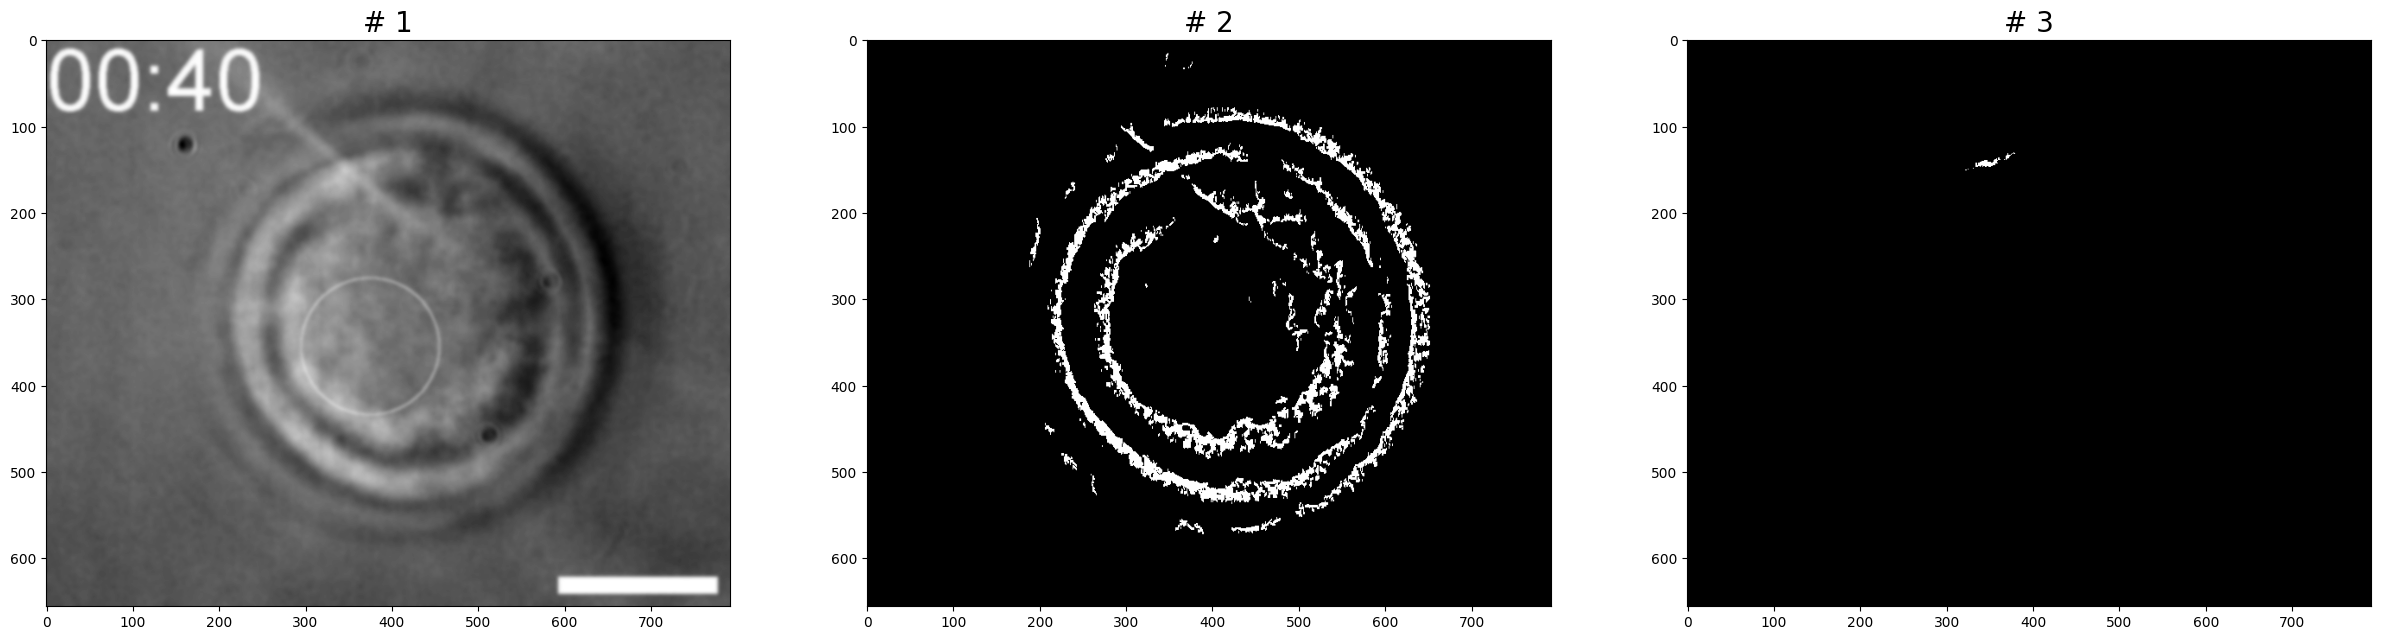

In [147]:
label_id = 33
msk = labels.copy()
msk[labels != label_id] = 0
display_images([gray, new_edge_binary, msk])

236


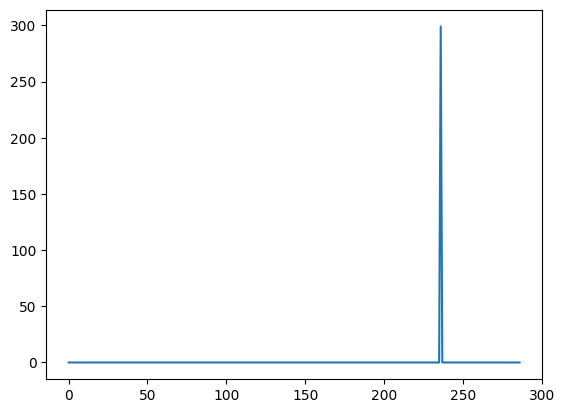

In [ ]:
def _compute_largest_brightness_diff_label_id(b2d_vector_image, nlabels, labels):
    large_diff_mask = b2d_vector_image.copy()
    large_diff_mask = delete_drawings(large_diff_mask)
    large_diff_mask[get_dilated_mask(p.dust_mask) == 1] = 0
    large_diff_mask[100:150, 140:200] = 0
    large_diff_mask[large_diff_mask < np.mean(b2d_vector_image) + np.std(b2d_vector_image)] = 0
    large_diff_mask[large_diff_mask > 0] = 1
    large_diff_mask = large_diff_mask.astype('uint8')

    labels[large_diff_mask == 0] = 0
    count_masked_labels = np.zeros(nlabels)
    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            label_id = labels[y, x]
            if label_id == 0:
                continue
            count_masked_labels[label_id] += 1

    return np.argmax(count_masked_labels)

def get_largest_brightness_diff_contour_id(edge_binary):
    nlabels, labels = cv2.connectedComponents(edge_binary.astype('uint8'))
    largest_brightness_diff_label_id = _compute_largest_brightness_diff_label_id(b2d_vector_image, nlabels, labels)
    label_mask = to_mask(labels, largest_brightness_diff_label_id)

    counts = np.zeros(len(contours))
    for i, contour in enumerate(contours):
        for element in contour:
            x, y = element[0]
            if label_mask[y, x] == 1:
                counts[i] += 1
    return np.argmax(counts)
